In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git  --user
    
    
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7z08wz87
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7z08wz87
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... - done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=e8d448c1b5043b424844e69e8f508c61a89d9d27a44a8308b178825907581995
  Stored in directory: /tmp/pip-ephem-wheel-cache-xvkgoy6y/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import pandas as pd
from torchvision.models import resnet50, ResNet50_Weights
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import torch.nn.functional as F
import time
import os
import random
from torch.autograd.profiler import record_function

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

np.random.seed(42)

Using cuda device


In [4]:
model_imagenet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device).eval()
# print(model_imagenet)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [5]:
model_clip, preprocess = clip.load("RN50", device=device)
# print(model_clip)

100%|███████████████████████████████████████| 244M/244M [00:06<00:00, 41.3MiB/s]


## 2.1
Do the visual encoders have the same architecture? If not, please describe and explain the differences. 
Resnet50 is based on the original paper of Residual Networks, without many modifications. It consists of residual connections to address the vanishing gradient problem during training of deep networks.
The base model of CLIP uses a ResNet50 with several modifications as an image encoder and uses a masked self-attention Transformer as a text encoder. These encoders are trained to maximize the similarity of (image, text) pairs via a contrastive loss. 


## 2.2
(i) What label hierarchy is used in ImageNet? 

ImageNet uses a hierarchical label structure known as WordNet hierarchy. WordNet is a lexical database of English words and their semantic relationships, organized into synsets (sets of synonyms) and hypernyms (words that are more general or abstract). The WordNet hierarchy organizes concepts into a tree-like structure, where each node represents a synset and may have multiple child nodes representing more specific concepts. This hierarchical organization allows for labels to capture varying levels of abstraction, from general categories to specific instances.

(ii) What does a synset mean? 

A synset (synonym set) represents a group of words that are synonymous or closely related in meaning. In WordNet, synsets are used to organize words into groups based on their semantic relationships.
Each synset in WordNet represents a distinct concept, and it contains a set of synonyms that are considered equivalent. For example, the synset for the word "car" might include synonyms like "automobile," "vehicle".

(iii) Could grouping objects based on synsets lead to problems for visual recognition? 

While grouping objects based on synsets provides a structured way to organize and label images, it also leads to challenges for visual recognition. This is because objects within the same synset can vary greatly in appearance, pose, lighting conditions, and context. Additionally, some synsets may contain objects that are visually similar but semantically different, leading to potential confusion for computer vision algorithms.

(iv) State 3 types of visual differences we can expect to see in images with objects corresponding to the same synset.
1. Appearance Variation: Objects within the same synset can exhibit diverse appearances due to factors such as color, texture, size, shape, and orientation. Consider images of different breeds of dogs belonging to the "dog" synset. Each breed may have distinct physical characteristics, such as fur color, ear shape, and body size, leading to significant appearance variation.
2. Contextual Variation: The context in which objects appear can vary widely, influencing their visual appearance and surroundings. Objects belonging to the same synset may appear in different environments, settings, or scenes, which can impact their visual appearance and the way they interact with other objects. For instance, a "chair" in a living room will have different contextual cues compared to a "chair" in a classroom or a restaurant.
3. Pose and Viewpoint Variation: Objects can exhibit different poses and viewpoints across images, affecting their visual representation. Variations in pose, angle, and viewpoint can lead to changes in object shape, orientation, and spatial arrangement relative to the camera. For example, images of cars in the "car" synset may capture vehicles from various angles, such as frontal views, side views, or rear views, resulting in pose and viewpoint differences.

In [6]:
with open("/kaggle/input/somephotosfromimagenet/imagenet_classes.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)

In [7]:
# predict the labels using ResNet50 trained on ImageNet
def ImageNetTop_5(image):
    with torch.no_grad():
        output = model_imagenet(image)
    probabilities = F.softmax(output, dim=1)
    top5_probabilities, top5_indices = torch.topk(probabilities, 5, dim=1)
    top5_probabilities = top5_probabilities.cpu().numpy()[0]
    top5_indices = top5_indices.cpu().numpy()[0]
    top5_labels = [class_names[idx] for idx in top5_indices]        
    return top5_labels, top5_probabilities

# predict labels using CLIP 
def CLIP_top5(image):
    with torch.no_grad():
        image_features = model_clip.encode_image(image)
        text_features = model_clip.encode_text(text_inputs)

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Cosine similarity as logits
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    # Get the top-5 categories
    probs, indices = logits[0].topk(5)
    top5_labels = [class_names[idx] for idx in indices]

    return top5_labels, probs

# predict labels using CLIP 
def CLIP_fp16_top5(image):
    with torch.no_grad():
        image_features = model_clip_fp16.encode_image(image)
        text_features = model_clip_fp16.encode_text(text_inputs)

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Cosine similarity as logits
        logits = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    # Get the top-5 categories
    probs, indices = logits[0].topk(5)
    top5_labels = [class_names[idx] for idx in indices]

    return top5_labels, probs

# function to select specified number of random files in a directory
def select_random_files(directory, num_files):
    file_list = os.listdir(directory)
    
    # Randomly select `num_files` file names without replacement
    selected_files = random.sample(file_list, num_files)
    
    # Convert file names to full file paths
    selected_filepaths = [os.path.join(directory, filename) for filename in selected_files]
    
    return selected_filepaths

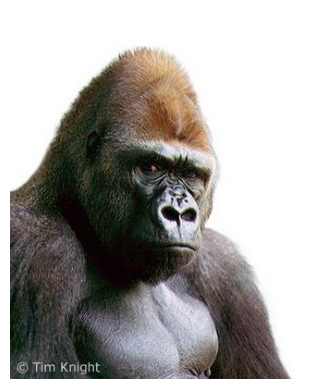


Top 5 predictions (ResNet (trained on ImageNet)) : 
366, gorilla	:	99.87 %
367, chimpanzee	:	0.05 %
365, orangutan	:	0.03 %
379, howler_monkey	:	0.01 %
368, gibbon	:	0.01 %

Top 5 predictions (CLIP)
366, gorilla	:	83.94 %
365, orangutan	:	7.45 %
367, chimpanzee	:	1.74 %
378, capuchin	:	1.29 %
379, howler_monkey	:	0.96 %



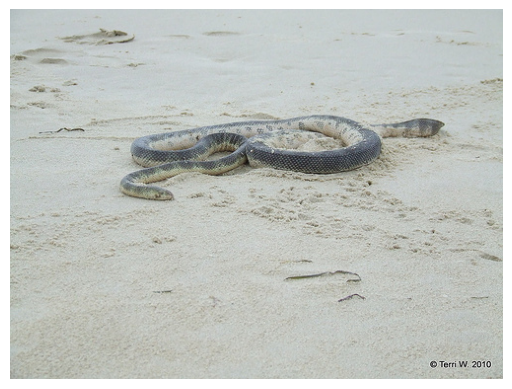


Top 5 predictions (ResNet (trained on ImageNet)) : 
65, sea_snake	:	86.83 %
58, water_snake	:	9.03 %
62, rock_python	:	2.0 %
54, hognose_snake	:	0.73 %
63, Indian_cobra	:	0.33 %

Top 5 predictions (CLIP)
54, hognose_snake	:	25.07 %
65, sea_snake	:	18.07 %
57, garter_snake	:	14.28 %
59, vine_snake	:	10.96 %
58, water_snake	:	10.13 %



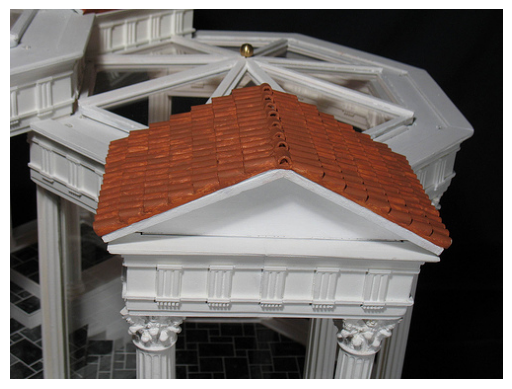


Top 5 predictions (ResNet (trained on ImageNet)) : 
448, birdhouse	:	33.24 %
538, dome	:	32.75 %
708, pedestal	:	7.47 %
716, picket_fence	:	5.36 %
437, beacon	:	2.62 %

Top 5 predictions (CLIP)
858, tile_roof	:	69.73 %
905, window_shade	:	3.93 %
873, triumphal_arch	:	1.49 %
520, crib	:	1.49 %
580, greenhouse	:	1.42 %



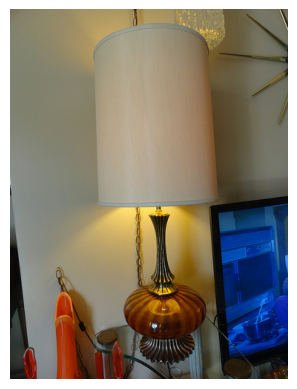


Top 5 predictions (ResNet (trained on ImageNet)) : 
846, table_lamp	:	89.1 %
619, lampshade	:	7.51 %
402, acoustic_guitar	:	0.5 %
526, desk	:	0.28 %
851, television	:	0.27 %

Top 5 predictions (CLIP)
846, table_lamp	:	36.38 %
619, lampshade	:	35.25 %
545, electric_fan	:	1.93 %
905, window_shade	:	1.78 %
542, drumstick	:	0.83 %



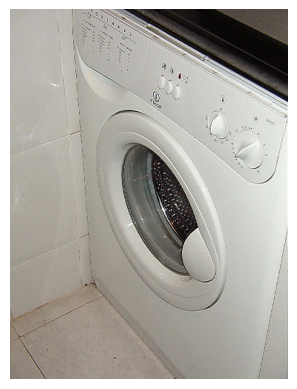


Top 5 predictions (ResNet (trained on ImageNet)) : 
897, washer	:	99.99 %
534, dishwasher	:	0.0 %
651, microwave	:	0.0 %
861, toilet_seat	:	0.0 %
827, stove	:	0.0 %

Top 5 predictions (CLIP)
897, washer	:	98.88 %
534, dishwasher	:	0.24 %
894, wardrobe	:	0.2 %
793, shower_cap	:	0.16 %
876, tub	:	0.05 %


In [8]:
image_paths = []
image_paths.append("/kaggle/input/somephotosfromimagenet/ILSVRC2012_val_00020811.JPEG")
image_paths.append("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00000001.JPEG")
image_paths.append("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00000030.JPEG")
image_paths.append("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test/ILSVRC2012_test_00000017.JPEG")
image_paths.append("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test/ILSVRC2012_test_00000903.JPEG")

for image_path in image_paths:
    image = matplotlib.image.imread(image_path)
    
    print()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    imagenet_top5, imagenet_top5prob = ImageNetTop_5(image)
    print("\nTop 5 predictions (ResNet (trained on ImageNet)) : ")
    for i in range(len(imagenet_top5)):
        print(imagenet_top5[i] + "\t:\t" + str(round(imagenet_top5prob[i].item()*100,2)) + " %")

    clip_top5, clip_top5prob = CLIP_top5(image)
    print("\nTop 5 predictions (CLIP)")
    for i in range(len(clip_top5)):
        print(clip_top5[i] + "\t:\t" + str(round(clip_top5prob[i].item()*100,2)) + " %")

## 2.5

In [9]:
model_clip_fp16, preprocess_fp16 = clip.load("RN50", device=device)

def convert_parameters_to_fp16(model):
    for name, param in model.named_parameters():
        if 'visual' in name:
            param.data = param.data.to(torch.float16)
            if param.grad is not None:
                param.grad.data = param.grad.data.to(torch.float16)

convert_parameters_to_fp16(model_clip_fp16)

# for name, param in model_clip_f16.named_parameters():
#     print(f"Parameter: {name}, dtype: {param.dtype}")

In [10]:
selected_filepaths = select_random_files("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test", 100)

fp32_times_list = []
fp16_times_list = []
for path in selected_filepaths:
    st_time = time.time()
    CLIP_top5(preprocess(Image.open(path)).unsqueeze(0).to(device))
    end_time = time.time()
    fp32_times_list.append(end_time-st_time)
    
    st_time = time.time()
    CLIP_fp16_top5(preprocess_fp16(Image.open(path)).unsqueeze(0).to(device))
    end_time = time.time()
    fp16_times_list.append(end_time-st_time)
    
fp32_times = np.array(fp32_times_list)
fp16_times = np.array(fp16_times_list)

print("\nfp32 : ")
print("mean : ", np.mean(fp32_times), "s", "\t variance : ", np.std(fp32_times), "s")
print("\nfp16 : ")
print("mean : ", np.mean(fp16_times), "s","\t variance : ", np.std(fp16_times), "s")


fp32 : 
mean :  1.0816135168075562 s 	 variance :  0.004903333350243692 s

fp16 : 
mean :  1.0728050017356872 s 	 variance :  0.0038441834464231395 s


## 2.5.1
As we can see here, the fp16 variant of CLIP is 0.01 seconds faster than the fp32 variant (actually a mix of fp16 and fp32, where the conv layers are fp16 and the rest are fp32). This is a slight increase in speed. But the variance of fp16 is much lesser than that of fp32, which means that most images take around the same time, which is not the case with fp32, since its variance is higher. Overall, fp16 is much more efficient in terms of image encoding speed.

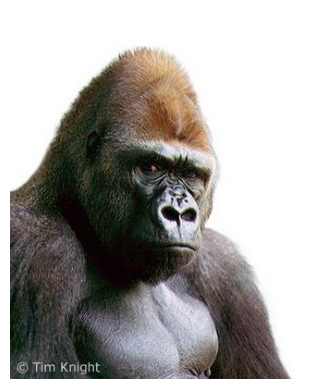


Top 5 predictions (CLIP)
366, gorilla	:	83.94 %
365, orangutan	:	7.45 %
367, chimpanzee	:	1.74 %
378, capuchin	:	1.29 %
379, howler_monkey	:	0.96 %

Top 5 predictions (CLIP F16)
366, gorilla	:	85.74 %
365, orangutan	:	7.49 %
367, chimpanzee	:	1.62 %
378, capuchin	:	1.03 %
372, baboon	:	0.53 %



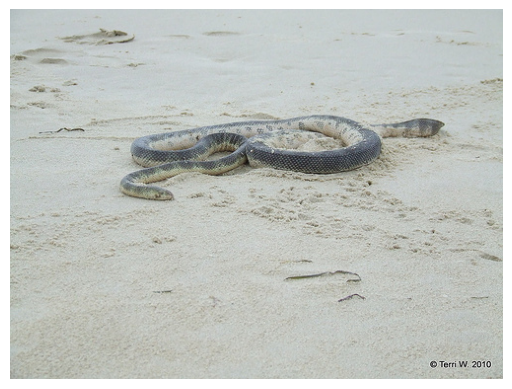


Top 5 predictions (CLIP)
54, hognose_snake	:	25.07 %
65, sea_snake	:	18.07 %
57, garter_snake	:	14.28 %
59, vine_snake	:	10.96 %
58, water_snake	:	10.13 %

Top 5 predictions (CLIP F16)
54, hognose_snake	:	24.84 %
65, sea_snake	:	18.46 %
57, garter_snake	:	13.94 %
59, vine_snake	:	10.85 %
58, water_snake	:	10.2 %



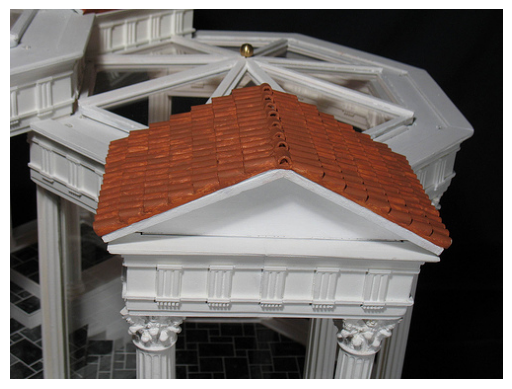


Top 5 predictions (CLIP)
858, tile_roof	:	69.73 %
905, window_shade	:	3.93 %
873, triumphal_arch	:	1.49 %
520, crib	:	1.49 %
580, greenhouse	:	1.42 %

Top 5 predictions (CLIP F16)
858, tile_roof	:	69.82 %
905, window_shade	:	3.94 %
873, triumphal_arch	:	1.5 %
520, crib	:	1.5 %
580, greenhouse	:	1.43 %



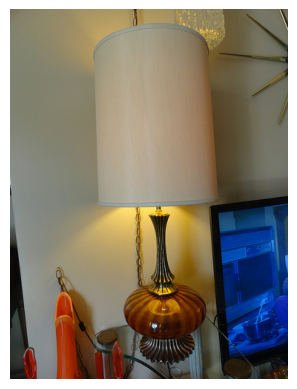


Top 5 predictions (CLIP)
846, table_lamp	:	36.38 %
619, lampshade	:	35.25 %
545, electric_fan	:	1.93 %
905, window_shade	:	1.78 %
542, drumstick	:	0.83 %

Top 5 predictions (CLIP F16)
846, table_lamp	:	36.57 %
619, lampshade	:	34.89 %
545, electric_fan	:	1.91 %
905, window_shade	:	1.76 %
542, drumstick	:	0.83 %



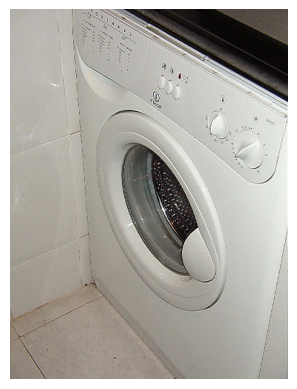


Top 5 predictions (CLIP)
897, washer	:	98.88 %
534, dishwasher	:	0.24 %
894, wardrobe	:	0.2 %
793, shower_cap	:	0.16 %
876, tub	:	0.05 %

Top 5 predictions (CLIP F16)
897, washer	:	98.88 %
534, dishwasher	:	0.24 %
894, wardrobe	:	0.2 %
793, shower_cap	:	0.16 %
876, tub	:	0.05 %


In [11]:
for image_path in image_paths:
    image = matplotlib.image.imread(image_path)
    
    print()
    plt.imshow(image)
    plt.axis('off')  
    plt.show()
    
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    
    clip_top5, clip_top5prob = CLIP_top5(image)
    print("\nTop 5 predictions (CLIP)")
    for i in range(len(clip_top5)):
        print(clip_top5[i] + "\t:\t" + str(round(clip_top5prob[i].item()*100,2)) + " %")

    image = preprocess_fp16(Image.open(image_path)).unsqueeze(0).to(device)

    clip_top5, clip_top5prob = CLIP_fp16_top5(image)
    print("\nTop 5 predictions (CLIP F16)")
    for i in range(len(clip_top5)):
        print(clip_top5[i] + "\t:\t" + str(round(clip_top5prob[i].item()*100,2)) + " %")

## 2.5.2
We see fairly significant difference in the confidence scores between fp32 and fp16 variant of the CLIP model. But suprisingly, the fp16 variant does better in terms of higher confidence score for the correct class. This can be seen in the examples above. One possible reason for this could be that fp16, having lesser precision, helps prevent overfitting, resulting in better results in general. Another reason is that the smaller precision also helps filter out noise, thereby increasing model accuracy. It also has a regularizing effect.

In [12]:
# GPU memory snapshot for fp32
torch.cuda.memory._record_memory_history(
       max_entries=100000
   )
for i in range(5):
    image = preprocess(Image.open(image_paths[i])).unsqueeze(0).to(device)
    CLIP_top5(image)

torch.cuda.memory._dump_snapshot(f"fp32.pickle")
torch.cuda.memory._record_memory_history(enabled=None)

# GPU memory snapshot for fp16
torch.cuda.memory._record_memory_history(
       max_entries=100000
   )
for i in range(5):
    image = preprocess_fp16(Image.open(image_paths[i])).unsqueeze(0).to(device)
    CLIP_fp16_top5(image)

torch.cuda.memory._dump_snapshot(f"fp16.pickle")
torch.cuda.memory._record_memory_history(enabled=None)

[W unwind.cpp:194] Warning: Unsupported unwinding pattern: Address not in range (function unwinderFor)


## 2.5.3 
The pickle files can be used to visualize the GPU memory usage during the forward pass of image encoding. It can be viewed by dropping the files [here](https://pytorch.org/memory_viz). As can be seen, there is not too much difference in the memory allocated for both variants. This is because the default model uses fp32 only for some parameters, not all of them. So, when I converted all of them to fp16, it did not make too much of a difference because only the layers which were not convolutions were changed from f32 to f16.

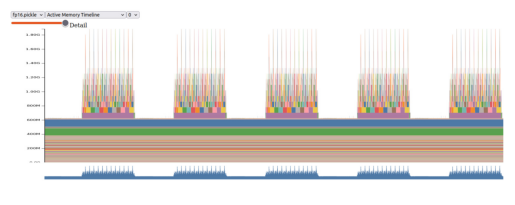

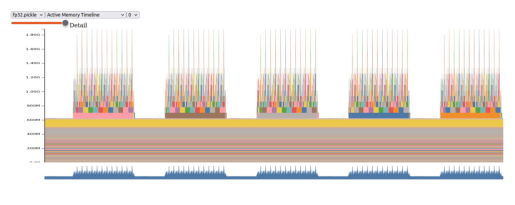

In [13]:
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/input/screenshots-of-gpu-mem/f16.jpeg")
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

img2 = mpimg.imread("/kaggle/input/screenshots-of-gpu-mem/f32.jpeg")
imgplot = plt.imshow(img2)
plt.axis('off')
plt.show()

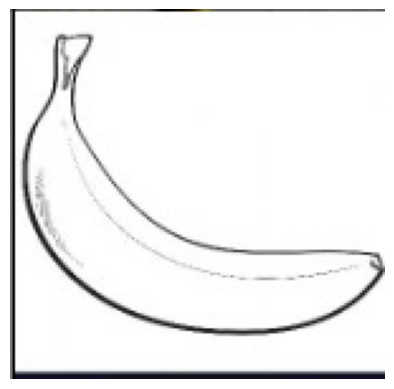


Top 5 predictions (ResNet (trained on ImageNet)) : 
111, nematode	:	55.91 %
488, chain	:	4.22 %
902, whistle	:	3.69 %
600, hook	:	3.49 %
451, bolo_tie	:	3.22 %

Top 5 predictions (CLIP)
111, nematode	:	18.63 %
942, butternut_squash	:	3.67 %
110, flatworm	:	3.67 %
459, brassiere	:	3.09 %
566, French_horn	:	2.44 %



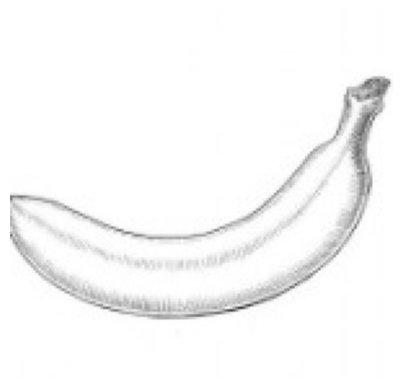


Top 5 predictions (ResNet (trained on ImageNet)) : 
111, nematode	:	98.38 %
600, hook	:	0.82 %
110, flatworm	:	0.09 %
623, letter_opener	:	0.08 %
902, whistle	:	0.06 %

Top 5 predictions (CLIP)
110, flatworm	:	9.52 %
111, nematode	:	5.42 %
942, butternut_squash	:	5.1 %
945, bell_pepper	:	4.03 %
114, slug	:	3.29 %



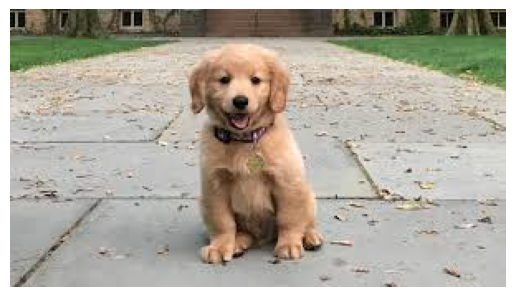


Top 5 predictions (ResNet (trained on ImageNet)) : 
207, golden_retriever	:	96.19 %
208, Labrador_retriever	:	1.66 %
222, kuvasz	:	0.39 %
220, Sussex_spaniel	:	0.16 %
206, curly-coated_retriever	:	0.12 %

Top 5 predictions (CLIP)
207, golden_retriever	:	43.75 %
206, curly-coated_retriever	:	14.2 %
208, Labrador_retriever	:	8.89 %
209, Chesapeake_Bay_retriever	:	6.71 %
267, standard_poodle	:	5.06 %



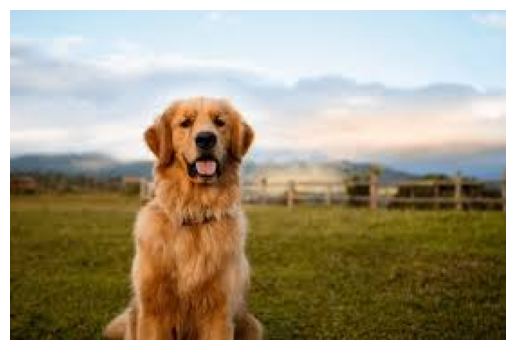


Top 5 predictions (ResNet (trained on ImageNet)) : 
207, golden_retriever	:	93.28 %
256, Newfoundland	:	1.78 %
220, Sussex_spaniel	:	0.99 %
255, Leonberg	:	0.8 %
208, Labrador_retriever	:	0.48 %

Top 5 predictions (CLIP)
207, golden_retriever	:	53.08 %
206, curly-coated_retriever	:	4.64 %
175, otterhound	:	4.43 %
238, Greater_Swiss_Mountain_dog	:	3.14 %
205, flat-coated_retriever	:	2.95 %



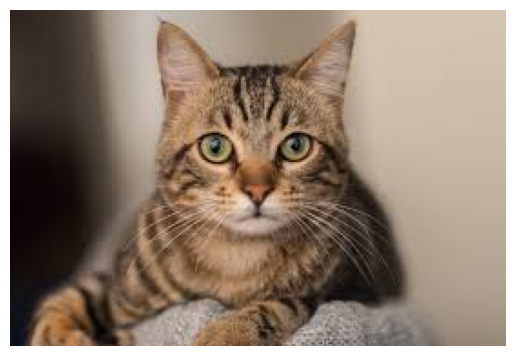


Top 5 predictions (ResNet (trained on ImageNet)) : 
281, tabby	:	71.96 %
285, Egyptian_cat	:	13.42 %
282, tiger_cat	:	11.21 %
287, lynx	:	0.42 %
728, plastic_bag	:	0.39 %

Top 5 predictions (CLIP)
285, Egyptian_cat	:	30.15 %
281, tabby	:	14.93 %
283, Persian_cat	:	7.87 %
282, tiger_cat	:	7.16 %
383, Madagascar_cat	:	6.73 %



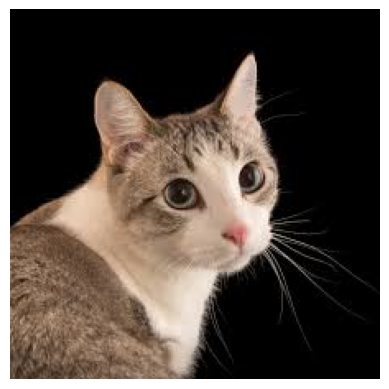


Top 5 predictions (ResNet (trained on ImageNet)) : 
285, Egyptian_cat	:	68.05 %
281, tabby	:	24.26 %
282, tiger_cat	:	3.23 %
287, lynx	:	1.44 %
284, Siamese_cat	:	0.5 %

Top 5 predictions (CLIP)
284, Siamese_cat	:	30.59 %
285, Egyptian_cat	:	17.98 %
383, Madagascar_cat	:	7.86 %
281, tabby	:	5.66 %
283, Persian_cat	:	3.6 %



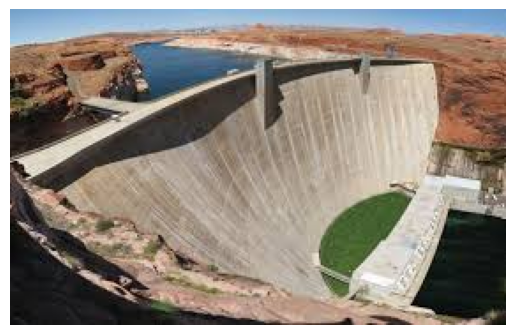


Top 5 predictions (ResNet (trained on ImageNet)) : 
525, dam	:	99.09 %
807, solar_dish	:	0.14 %
730, plow	:	0.14 %
408, amphibian	:	0.1 %
821, steel_arch_bridge	:	0.06 %

Top 5 predictions (CLIP)
525, dam	:	82.42 %
58, water_snake	:	1.27 %
658, mitten	:	0.51 %
979, valley	:	0.38 %
976, promontory	:	0.36 %



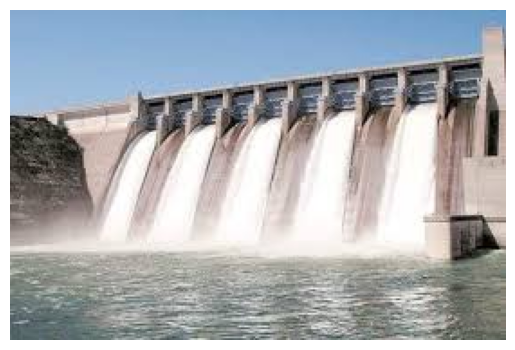


Top 5 predictions (ResNet (trained on ImageNet)) : 
525, dam	:	100.0 %
821, steel_arch_bridge	:	0.0 %
554, fireboat	:	0.0 %
814, speedboat	:	0.0 %
562, fountain	:	0.0 %

Top 5 predictions (CLIP)
525, dam	:	93.12 %
58, water_snake	:	0.64 %
460, breakwater	:	0.33 %
536, dock	:	0.21 %
395, gar	:	0.21 %



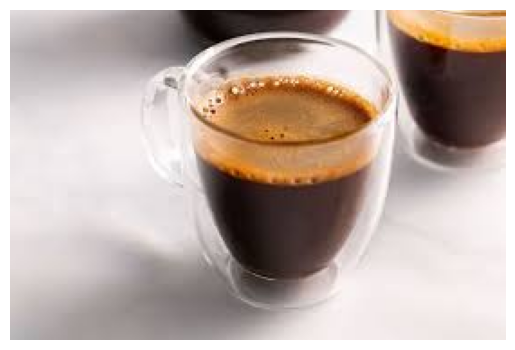


Top 5 predictions (ResNet (trained on ImageNet)) : 
967, espresso	:	98.97 %
925, consomme	:	0.61 %
969, eggnog	:	0.17 %
968, cup	:	0.1 %
550, espresso_maker	:	0.03 %

Top 5 predictions (CLIP)
967, espresso	:	75.05 %
505, coffeepot	:	5.97 %
925, consomme	:	4.58 %
550, espresso_maker	:	3.92 %
504, coffee_mug	:	1.42 %



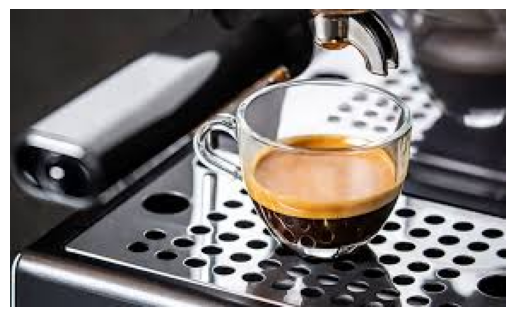


Top 5 predictions (ResNet (trained on ImageNet)) : 
967, espresso	:	56.23 %
550, espresso_maker	:	43.72 %
505, coffeepot	:	0.03 %
925, consomme	:	0.01 %
828, strainer	:	0.01 %

Top 5 predictions (CLIP)
967, espresso	:	49.02 %
550, espresso_maker	:	37.57 %
505, coffeepot	:	8.39 %
504, coffee_mug	:	0.73 %
925, consomme	:	0.68 %



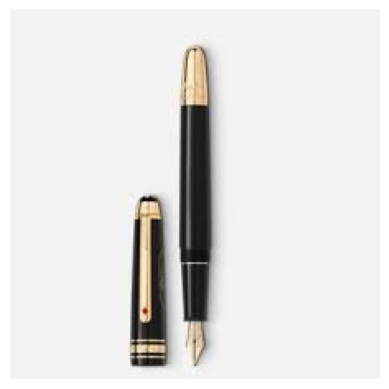


Top 5 predictions (ResNet (trained on ImageNet)) : 
563, fountain_pen	:	39.53 %
418, ballpoint	:	35.15 %
629, lipstick	:	18.23 %
767, rubber_eraser	:	1.45 %
623, letter_opener	:	0.73 %

Top 5 predictions (CLIP)
563, fountain_pen	:	48.05 %
629, lipstick	:	11.77 %
644, matchstick	:	6.81 %
127, white_stork	:	2.63 %
696, paintbrush	:	1.54 %



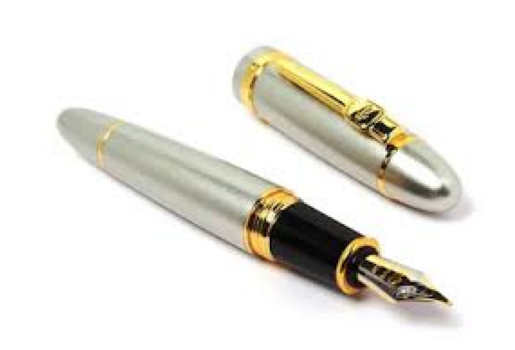


Top 5 predictions (ResNet (trained on ImageNet)) : 
563, fountain_pen	:	81.05 %
418, ballpoint	:	16.74 %
623, letter_opener	:	0.47 %
902, whistle	:	0.45 %
767, rubber_eraser	:	0.38 %

Top 5 predictions (CLIP)
563, fountain_pen	:	42.09 %
558, flute	:	6.45 %
784, screwdriver	:	6.06 %
776, sax	:	4.5 %
683, oboe	:	3.62 %


In [14]:
new_im_paths = []
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/banana1.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/banana2.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/dog1.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/dog2.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/cat1.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/cat2.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/dam1.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/dam2.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/espresso1.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/espresso2.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/fountainpen1.jpeg")
new_im_paths.append("/kaggle/input/screenshots-of-gpu-mem/fountainpen2.jpeg")
for image_path in new_im_paths:
    image = matplotlib.image.imread(image_path)
    
    print()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

    imagenet_top5, imagenet_top5prob = ImageNetTop_5(image)
    print("\nTop 5 predictions (ResNet (trained on ImageNet)) : ")
    for i in range(len(imagenet_top5)):
        print(imagenet_top5[i] + "\t:\t" + str(round(imagenet_top5prob[i].item()*100,2)) + " %")

    clip_top5, clip_top5prob = CLIP_top5(image)
    print("\nTop 5 predictions (CLIP)")
    for i in range(len(clip_top5)):
        print(clip_top5[i] + "\t:\t" + str(round(clip_top5prob[i].item()*100,2)) + " %")

## 2.4
As can be seen from the above examples, ResNet50 generally performs better than CLIP in most scenarios. These are evidenced by higher confidence scores for the correct label in ResNet compared to CLIP. Only in very few cases we see that CLIP performs slightly better. This can be seen in images that were given in the paper, for example, a sketch of a banana, on which CLIP performs better. I took the images from the internet, intending to match the class labels available on ImageNet. It also performs better in the fountain pen case. 

In the words of the paper, ' Zero-shot CLIP is much more robust to distribution shift than standard ImageNet models'. This is due to the additional input given to the CLIP model, in the form of text. Semantic Understanding,Cross-Modal Alignment and other factors allow the CLIP model to generalize better. It can be seen that CLIP sacrifices confidence for a higher chance to include the correct label in the top 5.